In [ ]:
!pip install pyspark duckdb
!wget -O "duckdb.jar" "https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar"
import pyspark
from pyspark.sql import SparkSession
import duckdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=82dad9a13e82611dbbcc1ed833e3c059e805bccd734df90b09ed51ee615bca4e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
--2024-04-24 12:34:08--  https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64009472 (61M) [application/java-archive]
Saving to: ‘duckdb.jar’

duckdb.jar          100%[===================>]  61.04M   205MB/s    in 0.3s    

2024-04-24 12:34:08 (205 MB/s) - ‘duckdb.jar’ saved [64009472/64009472]



In [ ]:
conn = duckdb.connect("database.duckdb")
conn.close()
spark = SparkSession.builder \
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

In [ ]:
from pyspark.sql import functions as F

In [ ]:
DF = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:database.duckdb") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", "SELECT * FROM airbnb") \
  .load()

DF.show()

+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+--------+
|           realSum|      room_type|room_shared|room_private|person_capacity|host_is_superhost|multi|biz|cleanliness_rating|guest_satisfaction_overall|bedrooms|              dist|        metro_dist|        attr_index|   attr_index_norm|        rest_index|   rest_index_norm|               lng|               lat|     city|day_type|
+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+--------+
|194

In [ ]:
from pyspark.sql import functions as F

We will check the missings of the dataset

In [ ]:
from pyspark.sql.functions import col, count, lit

total_rows = DF.count()
null_counts = DF.select([(total_rows - count(c)).alias(c) for c in DF.columns])
null_counts.show()

+-------+---------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+----+----------+----------+---------------+----------+---------------+---+---+----+--------+
|realSum|room_type|room_shared|room_private|person_capacity|host_is_superhost|multi|biz|cleanliness_rating|guest_satisfaction_overall|bedrooms|dist|metro_dist|attr_index|attr_index_norm|rest_index|rest_index_norm|lng|lat|city|day_type|
+-------+---------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+----+----------+----------+---------------+----------+---------------+---+---+----+--------+
|      0|        0|          0|           0|              0|                0|    0|  0|                 0|                         0|       0|   0|         0|         0|              0|         0|              0|  0|  0|   0|       0|
+-------+---------+-----------+------------+------------

As there are no missing values, we will check the description of the data

In [ ]:
# Description of the dataset
summary_stats = DF.describe()
summary_stats.show()

+-------+------------------+---------------+------------------+------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+--------+
|summary|           realSum|      room_type|   person_capacity|             multi|                biz|cleanliness_rating|guest_satisfaction_overall|          bedrooms|              dist|        metro_dist|        attr_index|   attr_index_norm|       rest_index|   rest_index_norm|              lng|              lat|     city|day_type|
+-------+------------------+---------------+------------------+------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+--

In [ ]:
# Obtain the extended stats
extended_stats = DF.summary()
extended_stats.show()

+-------+------------------+---------------+------------------+------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+--------+
|summary|           realSum|      room_type|   person_capacity|             multi|                biz|cleanliness_rating|guest_satisfaction_overall|          bedrooms|              dist|        metro_dist|        attr_index|   attr_index_norm|       rest_index|   rest_index_norm|              lng|              lat|     city|day_type|
+-------+------------------+---------------+------------------+------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+--

In [ ]:
from pyspark.sql.functions import col, count

# Initialize lists to store the results
unique_counts = []
null_counts = []

# Iterate over the columns
for column in DF.columns:
    # Count unique values
    unique_count = DF.select(column).distinct().count()
    unique_counts.append((column, unique_count))

    # Count null values
    null_count = DF.filter(col(column).isNull()).count()
    null_counts.append((column, null_count))

print("Valores únicos por columna:")
for col_name, u_count in unique_counts:
    print(f"{col_name}: {u_count}")

print("\nConteo de 'null' por columna:")
for col_name, n_count in null_counts:
    print(f"{col_name}: {n_count}")


Valores únicos por columna:
realSum: 10497
room_type: 3
room_shared: 2
room_private: 2
person_capacity: 5
host_is_superhost: 2
multi: 2
biz: 2
cleanliness_rating: 9
guest_satisfaction_overall: 53
bedrooms: 10
dist: 51707
metro_dist: 51707
attr_index: 51707
attr_index_norm: 51688
rest_index: 51707
rest_index_norm: 51688
lng: 23600
lat: 21484
city: 10
day_type: 2

Conteo de 'null' por columna:
realSum: 0
room_type: 0
room_shared: 0
room_private: 0
person_capacity: 0
host_is_superhost: 0
multi: 0
biz: 0
cleanliness_rating: 0
guest_satisfaction_overall: 0
bedrooms: 0
dist: 0
metro_dist: 0
attr_index: 0
attr_index_norm: 0
rest_index: 0
rest_index_norm: 0
lng: 0
lat: 0
city: 0
day_type: 0


However, we will check if there are missings not labeled as NaN

In [ ]:
from pyspark.sql.functions import col, when, count, upper

na_values = ["NA", "N/A", ""]
missing_value_counts = []

for column in DF.columns:

    formatted_column = upper(col(column).cast("string"))

    null_and_na_count = DF.select(formatted_column.alias(column)).filter(
        (formatted_column.isNull()) |
        (formatted_column.isin(na_values))
    ).count()

    missing_value_counts.append((column, null_and_na_count))

print("Conteo de valores faltantes por columna:")
for col_name, count in missing_value_counts:
    print(f"{col_name}: {count}")


Conteo de valores faltantes por columna:
realSum: 0
room_type: 0
room_shared: 0
room_private: 0
person_capacity: 0
host_is_superhost: 0
multi: 0
biz: 0
cleanliness_rating: 0
guest_satisfaction_overall: 0
bedrooms: 0
dist: 0
metro_dist: 0
attr_index: 0
attr_index_norm: 0
rest_index: 0
rest_index_norm: 0
lng: 0
lat: 0
city: 0
day_type: 0


In [ ]:
# Drop duplicates
DF = DF.dropDuplicates()

# Count the number of rows
num_rows = DF.count()

# Count the number of columns
num_columns = len(DF.columns)

print("Número de filas:", num_rows)
print("Número de columnas:", num_columns)

Número de filas: 51707
Número de columnas: 21


In [ ]:
from pyspark.sql.functions import col

# Check for hidden missing values
hidden_na_values = ["Unknown", "Not available", "Missing", "-", "."]

for column in DF.columns:
    for value in hidden_na_values:
        count = DF.filter(col(column) == value).count()
        if count > 0:
            print(f"La columna '{column}' tiene {count} registros con el valor oculto '{value}' considerado como missing.")


## Data Engineering

In [ ]:
from pyspark.sql.functions import when

# Create a new column with the cleanliness category
DF = DF.withColumn(
    "cleanliness_category",
    when(DF.cleanliness_rating < 5, "Low")
    .when(DF.cleanliness_rating < 8, "Medium")
    .otherwise("High")
)

In [ ]:
DF.show()

+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+---------+--------+--------------------+
|           realSum|      room_type|room_shared|room_private|person_capacity|host_is_superhost|multi|biz|cleanliness_rating|guest_satisfaction_overall|bedrooms|              dist|        metro_dist|        attr_index|   attr_index_norm|        rest_index|   rest_index_norm|              lng|               lat|     city|day_type|cleanliness_category|
+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+----

### Clustering

Now, we will make a clustering of the airbnb data to see if we can find some patterns in the data.

In [ ]:
from pyspark.sql.functions import udf, col, mean
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import rand
import math

k = 7  # Number of clusters
max_iterations = 20  # Maximum number of iterations


def distance(x, y):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(x, y)))

# Define and register the UDF
def assign_cluster(dist, metro_dist):
    point = (dist, metro_dist)
    distances = [distance(point, (c['dist'], c['metro_dist'])) for c in centroids]
    return distances.index(min(distances))

assign_cluster_udf = udf(assign_cluster, IntegerType())

# Initialize centroids
centroids = DF.orderBy(rand()).select("dist", "metro_dist").limit(k).collect()

# Apply K-means algorithm
DF = DF.withColumn("cluster", assign_cluster_udf(col("dist"), col("metro_dist")))
iteration = 0
converged = False

while not converged and iteration < max_iterations:
    iteration += 1

    new_centroids = DF.groupBy("cluster").agg(
        mean(col("dist")).alias("mean_dist"),
        mean(col("metro_dist")).alias("mean_metro_dist")
    ).collect()

    new_centroids = [{"dist": nc["mean_dist"], "metro_dist": nc["mean_metro_dist"]} for nc in new_centroids]
    centroid_changes = [distance((centroids[i]["dist"], centroids[i]["metro_dist"]),
                                 (nc["dist"], nc["metro_dist"])) for i, nc in enumerate(new_centroids)]

    converged = max(centroid_changes) < 0.01
    centroids = new_centroids
    print(f"Iteración {iteration}: Centroides = {centroids}")

# Show the results of each cluster
for i, centroid in enumerate(centroids):
    print(f"Cluster {i + 1}: Distancia media al centro = {centroid['dist']}, Distancia media al metro = {centroid['metro_dist']}")
    cluster_data = DF.filter(col("cluster") == i)
    cluster_data.show(truncate=False)


Iteración 1: Centroides = [{'dist': 1.9210908814804903, 'metro_dist': 1.3419778775533011}, {'dist': 3.832288679903858, 'metro_dist': 1.1762356442858395}, {'dist': 3.2559115907030827, 'metro_dist': 0.2858392851575018}, {'dist': 1.823214272749836, 'metro_dist': 0.4062825186098289}, {'dist': 0.783189814126987, 'metro_dist': 0.36047590158308435}, {'dist': 10.418630074839724, 'metro_dist': 2.725087199966681}, {'dist': 6.073540124781533, 'metro_dist': 0.8628768496171934}]
Iteración 2: Centroides = [{'dist': 1.9210908814804903, 'metro_dist': 1.3419778775533011}, {'dist': 3.832288679903858, 'metro_dist': 1.1762356442858395}, {'dist': 3.2559115907030827, 'metro_dist': 0.2858392851575018}, {'dist': 1.823214272749836, 'metro_dist': 0.4062825186098289}, {'dist': 0.783189814126987, 'metro_dist': 0.36047590158308435}, {'dist': 10.418630074839724, 'metro_dist': 2.725087199966681}, {'dist': 6.073540124781533, 'metro_dist': 0.8628768496171934}]
Cluster 1: Distancia media al centro = 1.9210908814804903,

In [ ]:
DF.show()

+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+---------+--------+--------------------+-------+
|           realSum|      room_type|room_shared|room_private|person_capacity|host_is_superhost|multi|biz|cleanliness_rating|guest_satisfaction_overall|bedrooms|              dist|        metro_dist|        attr_index|   attr_index_norm|        rest_index|   rest_index_norm|              lng|               lat|     city|day_type|cleanliness_category|cluster|
+------------------+---------------+-----------+------------+---------------+-----------------+-----+---+------------------+--------------------------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------

Explanation of each cluster:

Each cluster can be described by the averages of dist (distance to the city center) and metro_dist (distance to the nearest subway station). This can reveal different types of properties:

- Cluster with short distances to both: May represent accommodations in dense urban areas, close to transport and attractions.
- Cluster with large distances: May indicate accommodations in more residential or rural areas, potentially quieter and less expensive.
- Clusters with variations in one distance or the other: May represent areas with specific characteristics such as proximity to commercial areas without direct access to the subway, or vice versa.

Now, we will see the distribution of the clusters in the map

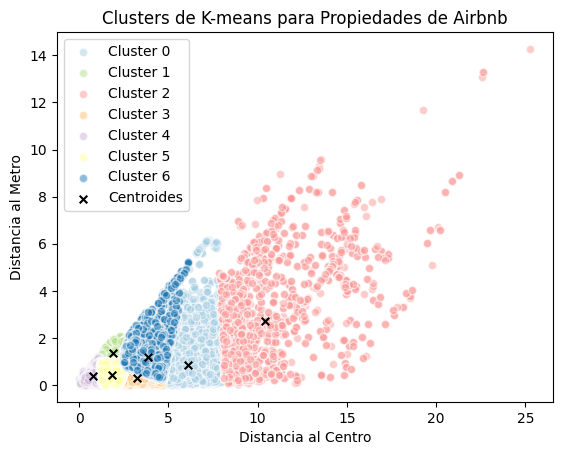

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = DF.select("dist", "metro_dist", "cluster").toPandas()

# Crear un scatter plot
fig, ax = plt.subplots()

colors = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99', '#1f78b4', '#33a02c', '#e31a1c', '#ff7f00']


for i in range(k):
    # Filtrar datos por cluster
    cluster_data = pandas_df[pandas_df['cluster'] == i]
    ax.scatter(cluster_data['dist'], cluster_data['metro_dist'], c=colors[i], label=f'Cluster {i}', alpha=0.5, edgecolors='w')


centroids_df = pd.DataFrame(centroids)
ax.scatter(centroids_df['dist'], centroids_df['metro_dist'], s=30, c='black', marker='x', label='Centroides')


ax.set_xlabel('Distancia al Centro')
ax.set_ylabel('Distancia al Metro')
ax.legend()

# Mostrar gráfico
plt.title('Clusters de K-means para Propiedades de Airbnb')
plt.show()

In [33]:
# Define the column types
column_types = {
    "realSum": "DOUBLE",
    "room_type": "STRING",
    "room_shared": "BOOLEAN",
    "room_private": "BOOLEAN",
    "person_capacity": "DOUBLE",
    "host_is_superhost": "BOOLEAN",
    "multi": "STRING",
    "biz": "STRING",
    "cleanliness_rating": "DOUBLE",
    "guest_satisfaction_overall": "DOUBLE",
    "bedrooms": "INT",
    "dist": "DOUBLE",
    "metro_dist": "DOUBLE",
    "attr_index": "DOUBLE",
    "attr_index_norm": "DOUBLE",
    "rest_index": "DOUBLE",
    "rest_index_norm": "DOUBLE",
    "lng": "DOUBLE",
    "lat": "DOUBLE",
    "city": "STRING",
    "day_type": "STRING",
    "cleanliness_category": "STRING",
    "cluster": "INT"
}

# Convert the dictionary to a string
column_types_str = ", ".join([f"{col} {data_type}" for col, data_type in column_types.items()])

# Save
DF.write \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:quality_database.duckdb") \
    .option("dbtable", "airbnb") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("createTableColumnTypes", column_types_str) \
    .save()